In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,LSTM,Dropout,BatchNormalization,Flatten
import random
import math
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
dataset = pd.read_csv("F:/Git_projects/LSTM_time series/RELIANCE.csv")

In [3]:
dataset.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,1/3/2000,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111320e+14,NaN,NaN,NaN
1,1/4/2000,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500220e+14,NaN,NaN,NaN
2,1/5/2000,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373700e+14,NaN,NaN,NaN
3,1/6/2000,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633250e+14,NaN,NaN,NaN
4,1/7/2000,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138390e+14,NaN,NaN,NaN


In [4]:
data = dataset.filter(["Close"],axis = 1)

In [5]:
data.head()

,Close
0,251.70
1,271.85
2,282.50
3,294.35
4,314.55


In [17]:
MS = MinMaxScaler(feature_range = (-1,1))
data = MS.fit_transform(np.array(data))

In [6]:
def scale_split(data,split_size):
    temp = int(split_size * len(data))
    val_size = len(data) - temp
    train_data,test_data = data[0:val_size,:],data[val_size:,:]
    return train_data,test_data


In [7]:
def create_dataset(data,timestep):
    x,y = [],[]
    for i in range(len(data) - timestep - 1):
        temp  = data[i:(i+timestep)]
        x.append(temp)
        y.append(data[i+timestep,0])
    return np.array(x),np.array(y)
        
        

In [8]:
train_data,test_data = scale_split(data,0.20)

In [9]:
timestep = 100
X_train,y_train = create_dataset(train_data,timestep)
X_test,y_test = create_dataset(test_data,timestep)

In [10]:
X_train.shape[1:]

(100, 1)

In [11]:
model = Sequential()

model.add(LSTM(50,input_shape = (X_train.shape[1:]),return_sequences = True))
#model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences = True))
#model.add(Dropout(0.2))

model.add(LSTM(50))
#model.add(Dropout(0.2))

model.add(Dense(64))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 54,129
Trainable params: 54,129
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss = "mean_squared_error",optimizer="adam")

In [13]:
model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 100,batch_size = 64)

Epoch 1/100
65/65 [==============================] - 18s 199ms/step - loss: 0.0826 - val_loss: 0.0051
Epoch 2/100
65/65 [==============================] - 10s 160ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 3/100
65/65 [==============================] - 11s 165ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 4/100
65/65 [==============================] - 11s 164ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 5/100
65/65 [==============================] - 11s 162ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 6/100
65/65 [==============================] - 11s 165ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 7/100
65/65 [==============================] - 11s 163ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 8/100
65/65 [==============================] - 11s 162ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 9/100
65/65 [==============================] - 11s 168ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 10/100
65/65 [==============================] - 11s 168ms/step - loss: 0.001

In [14]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [18]:
train_predict = MS.inverse_transform(train_predict)
test_predict = MS.inverse_transform(test_predict)

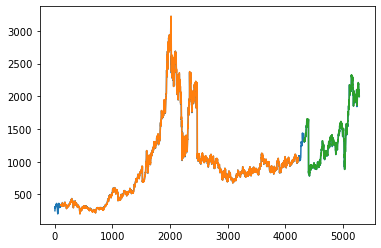

In [24]:
look_back=100
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(MS.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()